"""
Copyright 2026 Zsolt Bedőházi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

In [1]:
import sys
import os
import time
import random
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from classic_mil import Feature_attention
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as calc_auc
import matplotlib.pyplot as plt
import h5py
import json
from tqdm import tqdm

from omegaconf import OmegaConf

torch.set_num_threads(8)

In [2]:
CUDA_NUM = 0

In [3]:
conf_preproc = OmegaConf.load("../conf/preproc.yaml")
conf_train = OmegaConf.load("../conf/train.yaml")

conf_preproc = conf_preproc["project_mil"]
conf_train = conf_train["sote_finetuned_uni_224_224_patches_patients_rev_tuning"]

In [ ]:
conf_train.results_dir

In [ ]:
conf_train.cv_split_dir

### Functions and classes

In [6]:
def create_biopsy_subset(labels, minority_class_ratio=1.0, sampling_exponent=0.5, rnd_seed=38):
    # set random seed as given
    np.random.seed(rnd_seed)
    
    # collect selected biopsies that will be in the balanced subset
    test_local_idx = []
    
    # get current class occurences for biopsy
    class_occurence = np.array(list(dict( Counter(labels) ).values()))[ np.argsort(list(dict( Counter(labels) ).keys()))]

    # calc class weights
    class_weights = ( np.power(class_occurence, sampling_exponent) / np.power(class_occurence, sampling_exponent).sum() ).astype(np.float32)
    
    class_weights_dict = dict( zip( np.arange(class_weights.shape[0]), class_weights ))
    nr_class_minority = min( int(labels.shape[0]*np.min(class_weights)), np.min(class_occurence) )*minority_class_ratio 
    nr_class_test = (nr_class_minority * (class_weights * 1/np.min(class_weights))).astype(int)
    class_counts = []
    
    # collect biopsy indices for the balanced subset
    for e, s in enumerate(np.unique(labels)): #loop over labelss
        s_idx = np.arange(labels.shape[0])[labels == s]
        rnd_idx = np.random.permutation(s_idx.shape[0])
        class_counts.append(len(s_idx[rnd_idx[:nr_class_test[e]]]))
        test_local_idx.append(s_idx[rnd_idx[:nr_class_test[e]]])
        
    class_counts = np.array(class_counts)
    
    # aggregate all the balanced subset's indices
    test_idx = np.concatenate(test_local_idx)
    
    random.Random(23).shuffle(test_idx) # shuffle otherwise lables are ordered
    
    # other indices not in balanced set will be the rest
    train_idx = np.arange(labels.shape[0])[~np.isin(np.arange(labels.shape[0]), test_idx)]

    
    return train_idx, test_idx#, label_remaining[]

In [7]:
def give_back_balanced_training_fold( X_current, y_current,
                                      minority_class_ratio=0.5, sampling_exponent=0.5, rnd_seed=12 ):
    
    # remove later
    # minority_class_ratio =1.0
    
    _, test_idx, = create_biopsy_subset(y_current,
                                                 minority_class_ratio,
                                                 sampling_exponent,
                                                 rnd_seed)
    
    X_train_balanced = X_current[test_idx]
    y_train_balanced = y_current[test_idx]
    #y_train_balanced_oh = lb.transform(y_train_balanced)
    #print( X_train_balanced.shape, y_train_balanced_oh.shape )
    
    return X_train_balanced, y_train_balanced

### Load all data

In [8]:
biopsy_embeddings_folder = conf_preproc.uni_finetuned_biopsy_dir_macenko_new_bracs
file_paths = np.array(sorted( [biopsy_embeddings_folder + i for i in os.listdir(biopsy_embeddings_folder) if '.h5' in i ]))
file_paths.shape

(286,)

In [9]:
class CollectionsDataset(Dataset):
    def __init__(self,
                 data,
                 labels,
                 num_classes, 
                 transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, np.expand_dims(label,0)

In [10]:
# not modified
def train_loop(cur, X_train_all, y_train_all, X_val_all, y_val_all, results_dir, num_epochs, model, n_classes, loss_fn=None, gc=32):  
            
    device=torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu") 
    
    print('\nInit optimizer ...', end=' ')
    
    if conf_train["use_scheduler"]:
        print("\nUsing lr scheduler...")
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=conf_train.initial_lr, weight_decay=conf_train.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=conf_train.eta_min)
        
    else:
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=conf_train.lr, weight_decay=conf_train.weight_decay)
    
    print('Done!')
    
    train_loss_all_epoch = []
    val_loss_all_epoch = []
    val_auc_all_epoch = []
    max_auc_epoch = 0.
    
    # training loop with balanced folds
    for epoch in range(0, num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            
        ## TRAINING
        
        X_train, y_train = give_back_balanced_training_fold( X_train_all, y_train_all, 
                                                             minority_class_ratio=conf_train.minority_class_ratio,
                                                             sampling_exponent=conf_train.sampling_exponent,
                                                             rnd_seed=int(epoch*1.5+3*epoch))
        
        train_dataset = CollectionsDataset(data=X_train,
                                   labels=y_train,
                                   num_classes=3,
                                   transform=None)        

        train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=2, shuffle=False)
        
        model.train()
        train_loss = 0.
        train_error = 0.
        
        for bi, (data, label) in enumerate(train_dataset_loader):
            
            inputs = data
            label = label.squeeze(0)
            data = inputs.to(device, dtype=torch.float, non_blocking=True)
            label = label.to(device, dtype=torch.long, non_blocking=True)

            logits, Y_prob, Y_hat, _ = model(data)

            loss = loss_fn(logits, label)
            loss_value = loss.item()

            train_loss += loss_value

            error = calculate_error(Y_hat, label)
            train_error += error

            loss = loss / gc
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
        if conf_train["use_scheduler"]:
            scheduler.step()

        train_loss /= len(train_dataset_loader)
        train_error /= len(train_dataset_loader)
        #print('Train loss:', train_loss)
        
            
        ## VALIDATION
        val_dataset = CollectionsDataset(data=X_val_all,
                                       labels=y_val_all,
                                       num_classes=3,
                                       transform=None)
        
        val_dataset_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=2)
        
        stop, val_loss_epoch, auc_epoch, auc_separated = validate(model, val_dataset_loader, n_classes, loss_fn, results_dir)
        
        if auc_epoch > max_auc_epoch:
            max_auc_epoch = auc_epoch
            
        print('EPOCH: %3d    Train loss: %.3f    Val loss: %.3f    ROC_AUC: %.3f    Max AUC: %.4f  -    AUC_1: %.3f  AUC_2: %.3f  AUC_3: %.3f' % (epoch, train_loss, val_loss_epoch, auc_epoch, max_auc_epoch, *([float(x) for x in auc_separated]) )) 

        
        os.makedirs(results_dir + f"cv_{cur}/", exist_ok=True)
        torch.save(model.state_dict(), os.path.join(results_dir, f"cv_{cur}", 
                                                    f"epoch_{epoch}_trainloss_{np.round(train_loss,3)}_valloss_{np.round(val_loss_epoch,3)}_auc_{np.round(auc_epoch,3)}_"\
                                                    +'_'.join(auc_separated)+"_checkpoint.pt"))
        
        
        train_loss_all_epoch.append(train_loss)
        val_loss_all_epoch.append(val_loss_epoch)
        val_auc_all_epoch.append(auc_epoch)
        
        
    # Save training parameters to disk    
    param_dict = {'num_epochs': conf_train.num_epochs,
                  'train_loss_all_epoch': train_loss_all_epoch,
                  'val_loss_all_epoch': val_loss_all_epoch,
                  'val_auc_all_epoch': val_auc_all_epoch}
 
    return param_dict

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        # try to one-hot encode y_true
        y_true = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 3)

    plt.figure(figsize=(3, 3))

    for class_ind in range(y_pred.shape[-1]):
        fpr, tpr, _ = roc_curve(y_true[:, class_ind], y_pred[:, class_ind])
        auc = roc_auc_score(y_true[:, class_ind], y_pred[:, class_ind])
        plt.plot(fpr, tpr, '-', label='AUC : %.3f, label : %d' % (auc, class_ind))
    plt.legend()
    plt.show()

In [12]:
def validate(model, loader, n_classes, loss_fn = None, results_dir=None):
    device=torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu")
    
    # init variables and set mode to evaluation
    model.eval()
    val_loss = 0.
    val_error = 0.
    
    prob = np.zeros((len(loader), n_classes))
    labels = np.zeros(len(loader))

    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):

            data, label = batch
            label = label.squeeze(0)
            data = data.to(device, dtype=torch.float, non_blocking=True)
            label =  label.to(device, dtype=torch.long, non_blocking=True)
            
            logits, Y_prob, Y_hat, _ = model(data)  
            
            loss = loss_fn(logits, label)

            prob[batch_idx] = Y_prob.cpu().numpy()
            labels[batch_idx] = label.item()
            
            val_loss += loss.item()
            error = calculate_error(Y_hat, label)
            val_error += error
            

    val_error /= len(loader)
    val_loss /= len(loader)

    if n_classes == 2:
        auc = roc_auc_score(labels, prob[:, 1])

    else:
        #print("labels:", labels)
        #print("\n")
        #print("prob:", prob)
        auc = roc_auc_score(labels, prob, multi_class='ovr')
        
        auc_separated = []
        labels_oh = F.one_hot(torch.from_numpy(labels).to(torch.int64), 3)
        for class_ind in range(prob.shape[-1]):
            fpr, tpr, _ = roc_curve(labels_oh[:, class_ind], prob[:, class_ind])
            auc_current = np.round( roc_auc_score(labels_oh[:, class_ind], prob[:, class_ind]), 3 )
            auc_separated.append(str(auc_current))

    #print('\nVal Set, val_loss: {:.4f}, val_error: {:.4f}, auc: {:.4f}'.format(val_loss, val_error, auc))
        
    # print roc vurve
    #print(labels.shape, prob.shape)
    #plot_roc(labels, prob)

    return False, val_loss, auc, auc_separated

In [13]:
def calculate_error(Y_hat, Y):
    error = 1. - Y_hat.float().eq(Y.float()).float().mean().item()

    return error

### Training - test with CV

In [14]:
def seed_torch(seed=7):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    device=torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu") 
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [15]:
def load_h5_file_biopsy_bag(filename):
    with h5py.File(filename, "r") as f:
        features = f['features'][()]
        coords = f['coords'][()]
        slides = f['slides'][()]
        label = f['label'][()]
        return features, coords, slides, label

In [ ]:
def read_cv_data(data_df):
    embeddings_all = []
    labels_all = []
    
    file_paths = [ biopsy_embeddings_folder + str(filename) + '.h5' for filename in data_df.base_slide_number.values]#[:100]
    
    for num in tqdm(range( len(file_paths) )):
        
        embeddings, coords, slides, labels = load_h5_file_biopsy_bag(file_paths[num])

        # skip empty files:
        if embeddings.size == 0:
            print(f"Skipping empty file: {files[p]}")

        embeddings_all.append(embeddings)
        labels_all.append(labels)
            
    return np.array(embeddings_all, dtype=object), np.array(labels_all)-1

In [ ]:
conf_train["results_dir"]





##################################################################
###################### RUN - 0 ######################
##################################################################





 ############################ CV-Fold 0 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 98.71it/s] 


Init optimizer ... Done!


EPOCH:   0    Train loss: 1.120    Val loss: 1.120    ROC_AUC: 0.670    Max AUC: 0.6700  -    AUC_1: 0.741  AUC_2: 0.608  AUC_3: 0.661
EPOCH:   1    Train loss: 1.104    Val loss: 1.099    ROC_AUC: 0.682    Max AUC: 0.6823  -    AUC_1: 0.692  AUC_2: 0.608  AUC_3: 0.746
EPOCH:   2    Train loss: 1.115    Val loss: 1.095    ROC_AUC: 0.705    Max AUC: 0.7047  -    AUC_1: 0.721  AUC_2: 0.658  AUC_3: 0.736
EPOCH:   3    Train loss: 1.091    Val loss: 1.076    ROC_AUC: 0.693    Max AUC: 0.7047  -    AUC_1: 0.697  AUC_2: 0.617  AUC_3: 0.764
EPOCH:   4    Train loss: 1.099    Val loss: 1.073    ROC_AUC: 0.701    Max AUC: 0.7047  -    AUC_1: 0.690  AUC_2: 0.623  AUC_3: 0.789
EPOCH:   5    Train loss: 1.088    Val loss: 1.060    ROC_AUC: 0.697    Max AUC: 0.7047  -    AUC_1: 0.695  AUC_2: 0.608  AUC_3: 0.789
EPOCH:   6    Train loss: 1.096    Val loss: 1.060    ROC_AUC: 0.697    Max AUC: 0.7047  -    AUC_1: 0.687  AUC_2: 0.589  AUC_3: 0.814
EPOCH:   7    Train loss: 1.084    Val loss: 1.052    R

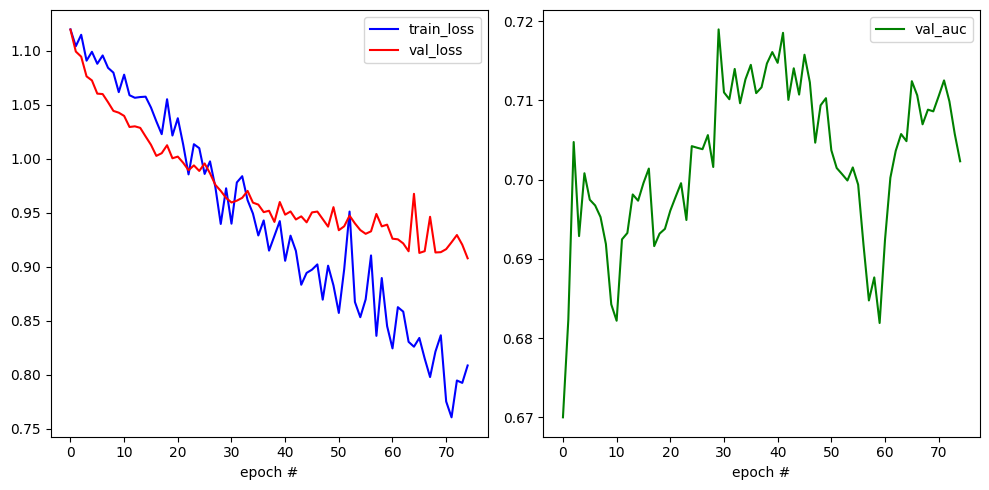


 ############################ CV-Fold 1 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 115.95it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 1.112    Val loss: 1.115    ROC_AUC: 0.611    Max AUC: 0.6111  -    AUC_1: 0.716  AUC_2: 0.585  AUC_3: 0.533
EPOCH:   1    Train loss: 1.105    Val loss: 1.094    ROC_AUC: 0.629    Max AUC: 0.6285  -    AUC_1: 0.702  AUC_2: 0.602  AUC_3: 0.582
EPOCH:   2    Train loss: 1.107    Val loss: 1.083    ROC_AUC: 0.635    Max AUC: 0.6349  -    AUC_1: 0.705  AUC_2: 0.628  AUC_3: 0.572
EPOCH:   3    Train loss: 1.110    Val loss: 1.086    ROC_AUC: 0.628    Max AUC: 0.6349  -    AUC_1: 0.707  AUC_2: 0.617  AUC_3: 0.559
EPOCH:   4    Train loss: 1.087    Val loss: 1.074    ROC_AUC: 0.629    Max AUC: 0.6349  -    AUC_1: 0.693  AUC_2: 0.641  AUC_3: 0.552
EPOCH:   5    Train loss: 1.091    Val loss: 1.071    ROC_AUC: 0.640    Max AUC: 0.6397  -    AUC_1: 0.696  AUC_2: 0.667  AUC_3: 0.556
EPOCH:   6    Train loss: 1.093    Val loss: 1.071    ROC_AUC: 0.649    Max AUC: 0.6487  -    AUC_1: 0.705  AUC_2: 0.689  AUC_3: 0.552
EPOCH:   7    Train loss: 1.085    Val loss: 1.064    R

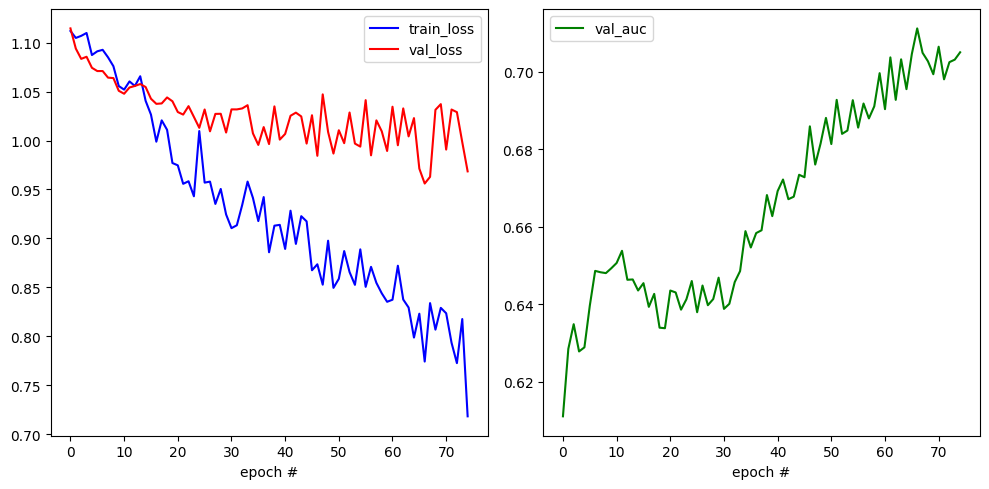


 ############################ CV-Fold 2 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 111.11it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 1.106    Val loss: 1.108    ROC_AUC: 0.610    Max AUC: 0.6097  -    AUC_1: 0.700  AUC_2: 0.587  AUC_3: 0.542
EPOCH:   1    Train loss: 1.110    Val loss: 1.098    ROC_AUC: 0.575    Max AUC: 0.6097  -    AUC_1: 0.679  AUC_2: 0.532  AUC_3: 0.513
EPOCH:   2    Train loss: 1.092    Val loss: 1.081    ROC_AUC: 0.572    Max AUC: 0.6097  -    AUC_1: 0.710  AUC_2: 0.487  AUC_3: 0.520
EPOCH:   3    Train loss: 1.103    Val loss: 1.079    ROC_AUC: 0.582    Max AUC: 0.6097  -    AUC_1: 0.726  AUC_2: 0.517  AUC_3: 0.503
EPOCH:   4    Train loss: 1.098    Val loss: 1.078    ROC_AUC: 0.548    Max AUC: 0.6097  -    AUC_1: 0.715  AUC_2: 0.426  AUC_3: 0.503
EPOCH:   5    Train loss: 1.057    Val loss: 1.060    ROC_AUC: 0.586    Max AUC: 0.6097  -    AUC_1: 0.731  AUC_2: 0.517  AUC_3: 0.510
EPOCH:   6    Train loss: 1.096    Val loss: 1.061    ROC_AUC: 0.578    Max AUC: 0.6097  -    AUC_1: 0.708  AUC_2: 0.506  AUC_3: 0.520
EPOCH:   7    Train loss: 1.081    Val loss: 1.060    R

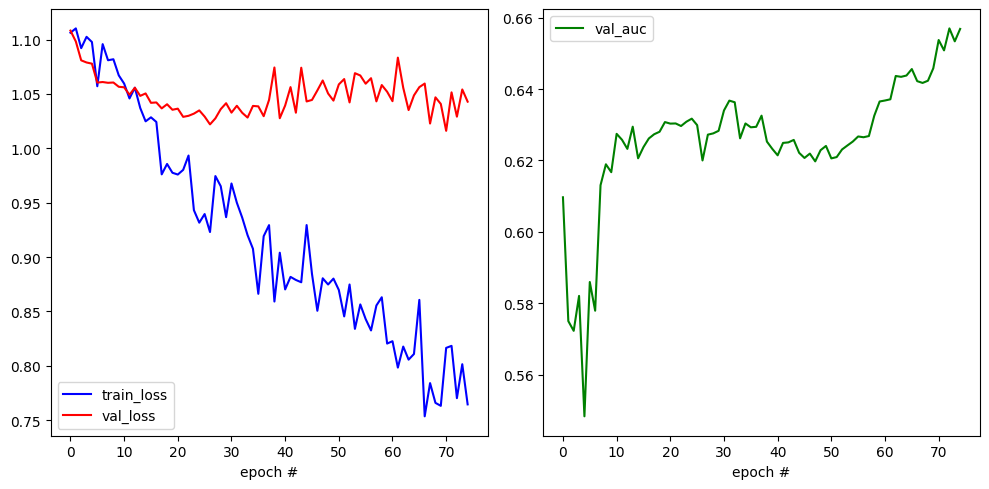


 ############################ CV-Fold 3 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 146.98it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 1.119    Val loss: 1.111    ROC_AUC: 0.569    Max AUC: 0.5694  -    AUC_1: 0.705  AUC_2: 0.526  AUC_3: 0.477
EPOCH:   1    Train loss: 1.105    Val loss: 1.093    ROC_AUC: 0.516    Max AUC: 0.5694  -    AUC_1: 0.713  AUC_2: 0.383  AUC_3: 0.451
EPOCH:   2    Train loss: 1.085    Val loss: 1.074    ROC_AUC: 0.492    Max AUC: 0.5694  -    AUC_1: 0.700  AUC_2: 0.329  AUC_3: 0.448
EPOCH:   3    Train loss: 1.113    Val loss: 1.080    ROC_AUC: 0.507    Max AUC: 0.5694  -    AUC_1: 0.700  AUC_2: 0.344  AUC_3: 0.477
EPOCH:   4    Train loss: 1.091    Val loss: 1.073    ROC_AUC: 0.524    Max AUC: 0.5694  -    AUC_1: 0.728  AUC_2: 0.357  AUC_3: 0.487
EPOCH:   5    Train loss: 1.090    Val loss: 1.067    ROC_AUC: 0.555    Max AUC: 0.5694  -    AUC_1: 0.718  AUC_2: 0.444  AUC_3: 0.503
EPOCH:   6    Train loss: 1.086    Val loss: 1.064    ROC_AUC: 0.606    Max AUC: 0.6059  -    AUC_1: 0.718  AUC_2: 0.593  AUC_3: 0.507
EPOCH:   7    Train loss: 1.070    Val loss: 1.058    R

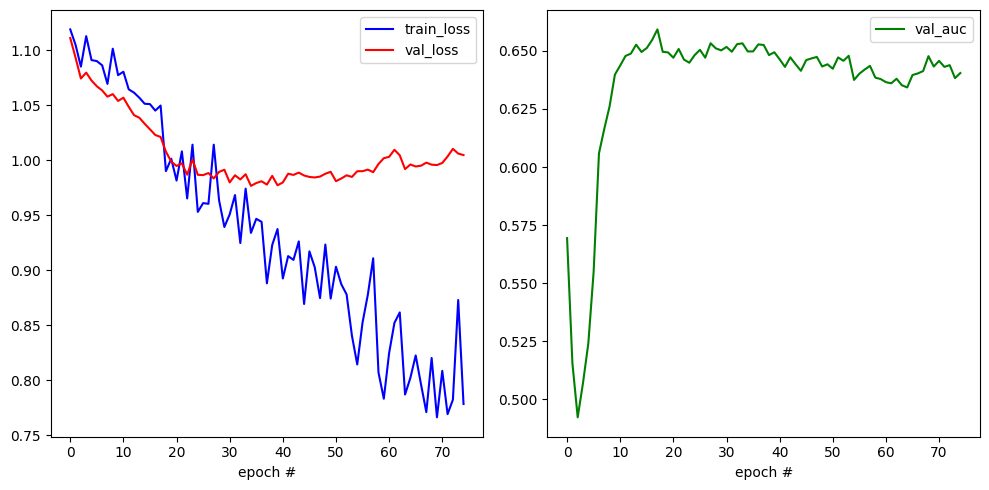


 ############################ CV-Fold 4 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 42/42 [00:00<00:00, 141.28it/s]



Init optimizer ... Done!
EPOCH:   0    Train loss: 1.106    Val loss: 1.107    ROC_AUC: 0.723    Max AUC: 0.7225  -    AUC_1: 0.817  AUC_2: 0.560  AUC_3: 0.790
EPOCH:   1    Train loss: 1.097    Val loss: 1.081    ROC_AUC: 0.680    Max AUC: 0.7225  -    AUC_1: 0.857  AUC_2: 0.426  AUC_3: 0.757
EPOCH:   2    Train loss: 1.091    Val loss: 1.073    ROC_AUC: 0.713    Max AUC: 0.7225  -    AUC_1: 0.865  AUC_2: 0.510  AUC_3: 0.765
EPOCH:   3    Train loss: 1.070    Val loss: 1.054    ROC_AUC: 0.703    Max AUC: 0.7225  -    AUC_1: 0.865  AUC_2: 0.510  AUC_3: 0.735
EPOCH:   4    Train loss: 1.075    Val loss: 1.049    ROC_AUC: 0.720    Max AUC: 0.7225  -    AUC_1: 0.862  AUC_2: 0.556  AUC_3: 0.743
EPOCH:   5    Train loss: 1.104    Val loss: 1.055    ROC_AUC: 0.733    Max AUC: 0.7330  -    AUC_1: 0.881  AUC_2: 0.565  AUC_3: 0.754
EPOCH:   6    Train loss: 1.103    Val loss: 1.059    ROC_AUC: 0.722    Max AUC: 0.7330  -    AUC_1: 0.878  AUC_2: 0.535  AUC_3: 0.754
EPOCH:   7    Train loss: 1.0

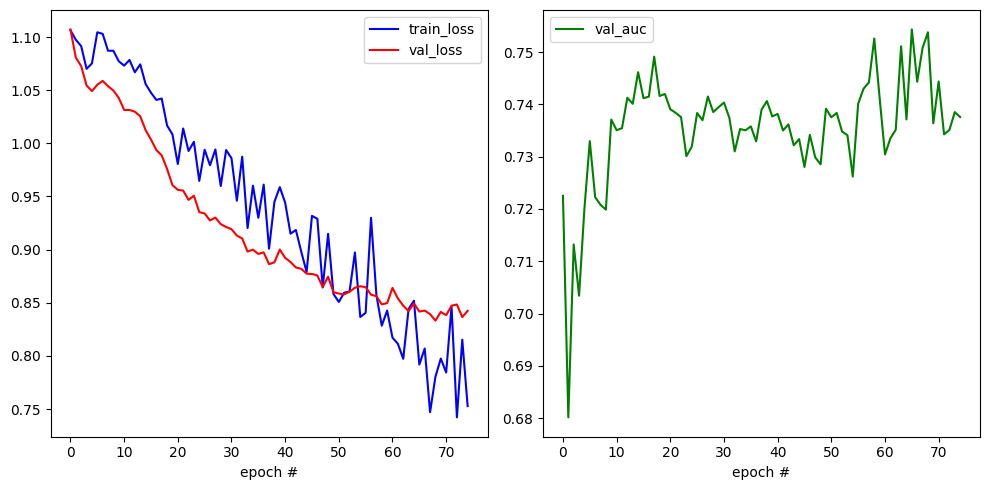

Max AUC in folds:  [np.float64(0.718964368964369), np.float64(0.7112252103300696), np.float64(0.6569791863909512), np.float64(0.6592459827753946), np.float64(0.7543609029229139)]
Mean AUC:  0.7001551302767397


In [18]:
for n_experiment in range(conf_train.n_experiment):

    print('\n')
    print('\n')
    print(f'##################################################################')
    print(f'###################### RUN - {n_experiment} ######################')
    print(f'##################################################################')
    print('\n')
    print('\n')
    max_val_aucs_all_epoch = []

    for i in range(5):

        print(f'\n ############################ CV-Fold {i} - Balanced training ############################')
        seed_torch(n_experiment)

        print('\nInit loss function...', end=' ')
        loss_fn = nn.CrossEntropyLoss()
        print('Done!')

        print('\nInit Model...', end=' ')
        device = torch.device(f'cuda:{CUDA_NUM}' if torch.cuda.is_available() else 'cpu')
        model = Feature_attention( conf_train.emb_dim, 
                                   conf_train.hidden_dim, 
                                   conf_train.att_hidden_dim,
                                   conf_train.dropout_fc,
                                   conf_train.dropout_attn, 
                                   conf_train.n_classes).to(device)
        print('Done!')

        train_df = pd.read_csv(f'{conf_train["cv_split_dir"]}train_split_multi_stratified_{i}.csv')
        val_df = pd.read_csv(f'{conf_train["cv_split_dir"]}val_split_multi_stratified_{i}.csv')

        X_train_all, y_train_all = read_cv_data(train_df)
        X_val_all, y_val_all = read_cv_data(val_df)
        
        #print(np.unique(y_train_all))
        #print(np.unique(y_val_all))

        results_dir = conf_train.results_dir + f'experiment_{n_experiment}/'
        #print("Results dir: ", results_dir)
        os.makedirs(results_dir, exist_ok=True)
        OmegaConf.save(config=OmegaConf.create(conf_train), f=results_dir+"conf_train.yaml")

        num_epochs = conf_train.num_epochs
        batch_size = conf_train.batch_size
        n_classes = conf_train.n_classes
        
        param_dict = train_loop(i, X_train_all, y_train_all, X_val_all, y_val_all, 
                                results_dir, num_epochs, model, n_classes, loss_fn, gc=32)
        
        max_val_aucs_all_epoch.append( np.max(param_dict['val_auc_all_epoch']) )


        json_data = {'num_epochs': param_dict['num_epochs'],
                     'train_loss_all_epoch_cv': param_dict['train_loss_all_epoch'],
                     'val_loss_all_epoch_all_cv': param_dict['val_loss_all_epoch'],
                     'val_auc_all_epoch_all_cv': param_dict['val_auc_all_epoch'],
                     'min_val_loss': np.min(param_dict['val_loss_all_epoch']),
                     'max_val_auc': np.max(param_dict['val_auc_all_epoch'])}

        # Save training parameters to disk    
        with open(results_dir + f"cv_{i}/" 'test_params.json', 'w') as file:
            json.dump(json_data, file)

        """    
        # plot curves
        plt.figure(figsize=(6,6))
        plt.plot(json_data['train_loss_all_epoch_cv'], "-b", label="train_loss")
        plt.plot(json_data['val_loss_all_epoch_all_cv'], "-r", label="val_loss")
        plt.legend(loc="upper right")

        plt.figure(figsize=(6,6))
        plt.plot(json_data['val_auc_all_epoch_all_cv'], "-g", label="val_auc")
        plt.legend(loc="upper right")
        """
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.plot(json_data['train_loss_all_epoch_cv'], "-b", label="train_loss")
        ax1.plot(json_data['val_loss_all_epoch_all_cv'], "-r", label="val_loss")
        ax1.set_xlabel('epoch #')
        ax1.legend()

        ax2.plot(json_data['val_auc_all_epoch_all_cv'], "-g", label="val_auc")
        ax2.set_xlabel('epoch #')
        ax2.legend()

        plt.tight_layout()
        plt.show()
        
        
        # free memory !
        del X_train_all, y_train_all, X_val_all, y_val_all

    print('Max AUC in folds: ', max_val_aucs_all_epoch)
    print('Mean AUC: ', np.mean(max_val_aucs_all_epoch))

In [19]:
max_val_aucs_all_epoch

[np.float64(0.718964368964369),
 np.float64(0.7112252103300696),
 np.float64(0.6569791863909512),
 np.float64(0.6592459827753946),
 np.float64(0.7543609029229139)]

In [20]:
np.mean(max_val_aucs_all_epoch)

np.float64(0.7001551302767397)